In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from riskyneuroarousal.utils.load_data import load_behavioral_data, load_pupil_data
%load_ext rpy2.ipython

##### Load the data
Remove RT outliers (defined as any response time less than 0.2 seconds). This also eliminates the trials where the subject did not respond.

In [2]:
data = load_behavioral_data(min_RT = 0.2)
shared_gains = [10, 12, 14, 16, 18, 20]

In [3]:
print("Acceptance rate across all gambles:")
print("EqualIndifference mean acceptance rate:", data.query("condition == 'equalIndifference'")["accept"].mean())
print("EqualRange mean acceptance rate:", data.query("condition == 'equalRange'")["accept"].mean())

Acceptance rate across all gambles:
EqualIndifference mean acceptance rate: 0.65746339331245
EqualRange mean acceptance rate: 0.45013123359580054


In [4]:
print("Acceptance rate for shared gambles:")
print("EqualIndifference mean acceptance rate:", data.query("condition == 'equalIndifference' & gain in @shared_gains")["accept"].mean())
print("EqualRange mean acceptance rate:", data.query("condition == 'equalRange' & gain in @shared_gains")["accept"].mean())

Acceptance rate for shared gambles:
EqualIndifference mean acceptance rate: 0.3714785311832135
EqualRange mean acceptance rate: 0.5766011290636558


### Analysis of acceptance rate
**Question: How does gain and loss affect acceptance rate? Does it change based on the condition?**

Model 1: Predict acceptance rate as a function of condition, gain and loss

In [5]:
%%R -i data
library(lme4)
library(lmerTest)

Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



In [6]:
%%R
model1 <- glmer(accept ~ condition*gain + condition*loss + (1|sub), data=data, family=binomial)
summary(model1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: accept ~ condition * gain + condition * loss + (1 | sub)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 15626.8  15684.4  -7806.4  15612.8    27436 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-188.535   -0.237    0.028    0.258   63.728 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 3.172    1.781   
Number of obs: 27443, groups:  sub, 108

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               0.318584   0.265135   1.202   0.2295    
conditionequalRange      -0.843328   0.371867  -2.268   0.0233 *  
gain                      0.292966   0.005767  50.799  < 2e-16 ***
loss                     -0.467691   0.010033 -46.615  < 2e-16 ***
conditionequalRange:gain  0.235372   0.011609  20.276  < 2e-16 ***
conditionequalRange:loss -0.064168   0.01

In [8]:
%%R
# Model comparison 
model2 <- glmer(accept ~ condition + gain + loss + (1|sub), data=data, family=binomial)
anova(model1, model2)

Data: data
Models:
model2: accept ~ condition + gain + loss + (1 | sub)
model1: accept ~ condition * gain + condition * loss + (1 | sub)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
model2    5 16271 16312 -8130.3    16261                         
model1    7 15627 15684 -7806.4    15613 647.79  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


**Findings:**
1. No significant effect of condition on acceptance rate
2. For the equalIndifference condition, there is a significant effect of gain on acceptance rate.
    * Log-odds increases by 0.321 (w/ all participants, its 0.293)
3. For the equalRange condition, there is a significant effect of gain on acceptance rate.
    * Log-odds increases by 0.707 (w/ all participants, its 0.528)
4. For the equalIndifference condition, there is a significant effect of loss on acceptance rate.
    * Log-odds decreases by 0.476 (w/ all participants, its 0.468)
5. For the equalRange condition, there is a significant effect of loss on acceptance rate.
    * Log-odds decreases by 0.683 (w/ all participants, its 0.532)

For equalIndifference, the ratio for loss/gain is 0.476/0.321 = 1.483 (loss averse behavior, w/ all participants its 1.802). For equalRange, the ratio for loss/gain is 0.683/0.707 = 0.966 (not loss averse, w/ all participants its 1.151).

After model comparison, we find that gain and loss interact with the condition. 

### Analysis of response time
**Question: What are the differences in response time between conditions? Are acceptances faster than rejections between conditions?**

Model 2: Predict response time as a function of condition, gain, loss, distance from indifference and response.


In [9]:
equalIndiff_rows = data["condition"] == "equalIndifference"
data.loc[equalIndiff_rows, "dist_from_indiff"] = np.abs(data[equalIndiff_rows]["gain"] - 1.8*data[equalIndiff_rows]["loss"]) / np.square(1 + 1.8**2)
equalRange_rows = data["condition"] == "equalRange"
data.loc[equalRange_rows, "dist_from_indiff"] = np.abs(data[equalRange_rows]["gain"] - 1.15*data[equalRange_rows]["loss"]) / np.square(1 + 1.15**2)

In [10]:
%%R -i data
# Is there an effect of accepting on response time between conditions? And if so, is this due to the gain and loss?
# Model 2: Predict Response Time as a function of condition, gain, loss, distance from indifference and response.
model3 <- lmer(RT ~ gain*condition + loss*condition + dist_from_indiff*condition + (1|sub), data=data)
summary(model3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain * condition + loss * condition + dist_from_indiff *  
    condition + (1 | sub)
   Data: data

REML criterion at convergence: 39715

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7471 -0.6700 -0.1583  0.5100  5.4269 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.1059   0.3254  
 Residual             0.2437   0.4937  
Number of obs: 27443, groups:  sub, 108

Fixed effects:
                                       Estimate Std. Error         df t value
(Intercept)                           1.767e+00  4.768e-02  1.399e+02  37.058
gain                                 -2.495e-03  4.683e-04  2.733e+04  -5.329
conditionequalRange                  -1.462e-01  6.741e-02  1.399e+02  -2.169
loss                                  1.559e-02  9.294e-04  2.733e+04  16.778
dist_from_indiff                     -3.676e-01  1.080e-02  2.733e+04 -34.031


In [11]:
%%R
# Post-hoc tests for condition equalRange
model4 <- lmer(RT ~ gain + loss + dist_from_indiff + (1 |sub), data=data[data$condition == 'equalRange', ])
summary(model4)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain + loss + dist_from_indiff + (1 | sub)
   Data: data[data$condition == "equalRange", ]

REML criterion at convergence: 18853.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7853 -0.6670 -0.1640  0.5097  5.6288 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.1047   0.3236  
 Residual             0.2266   0.4760  
Number of obs: 13716, groups:  sub, 54

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       1.621e+00  4.721e-02  6.881e+01  34.329  < 2e-16 ***
gain             -2.848e-03  9.064e-04  1.366e+04  -3.142  0.00168 ** 
loss              1.307e-02  9.224e-04  1.366e+04  14.174  < 2e-16 ***
dist_from_indiff -1.337e-01  5.606e-03  1.366e+04 -23.848  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) gai

In [12]:
%%R
# Post-hoc tests for condition equalIndifference
model5 <- lmer(RT ~ gain + loss + dist_from_indiff + (1|sub), data=data[data$condition == 'equalIndifference', ])
summary(model5)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain + loss + dist_from_indiff + (1 | sub)
   Data: data[data$condition == "equalIndifference", ]

REML criterion at convergence: 20793.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6551 -0.6774 -0.1530  0.5104  5.0059 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.1070   0.3271  
 Residual             0.2609   0.5107  
Number of obs: 13727, groups:  sub, 54

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       1.767e+00  4.813e-02  7.103e+01  36.711  < 2e-16 ***
gain             -2.495e-03  4.845e-04  1.367e+04  -5.151 2.63e-07 ***
loss              1.559e-02  9.615e-04  1.367e+04  16.218  < 2e-16 ***
dist_from_indiff -3.676e-01  1.117e-02  1.367e+04 -32.896  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (In

**Findings:**
1. Condition has no significant effect on response time.
2. In high reward condition, there is a significant effect of gain on response time.
    * Beta of 0.021 (0.023 w/ all participants)
3. In low reward condition, there is a significant effect of gain on response time.
    * Beta of 0.001 (0.003 w/ all participants)
    * This is slightly significant after post-hoc analysis. 
4. In high reward condition, there is not a significant effect of loss on response time.
5. In low reward condition, there is a significant effect of loss on response time.
    * Beta of 0.009
6. In high reward condition, there is a significant effect of distance from indifference on response time.
    * Beta of -0.05
7. In low reward condition, there is not a significant effect of distance from indifference on response time.
    * Beta of -0.03
8. In high reward condition, there is a significant effect of accepting on response time.
    * Beta of 0.098
9. In low reward condition, there is a significant effect of accepting on response time.
    * Beta of -0.01
    * This is not significant after post-hoc analysis. 

For the high reward condition, increasing gains make people respond faster, while increasing losses has no effect. In the low reward condition, this effect is reversed: increasing gains causes no effect on response time, while increasing losses makes people respond faster.

For both conditions, the distance from indifference makes response times faster (the high reward condition is a little more pronounced). 

Finally, accept trials are slower than reject trials in the high reward condition, but not in the low reward condition. This effect is not due to the gains, losses or distance from indifference seen in the trials. 

### Visualization of response times: 


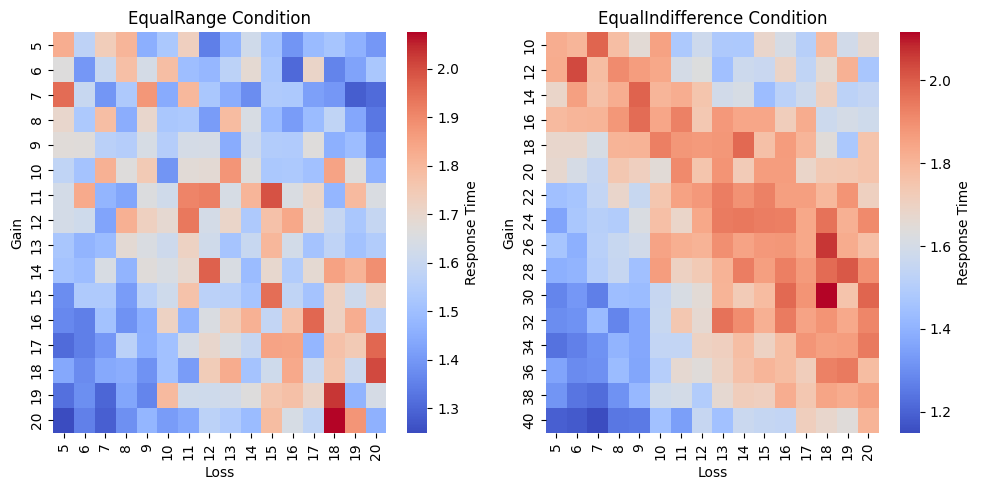

In [13]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("condition == 'equalRange'").groupby(['gain', 'loss'])['RT'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[0])
axs[0].set_title("EqualRange Condition")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['RT'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[1])
axs[1].set_title("EqualIndifference Condition")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

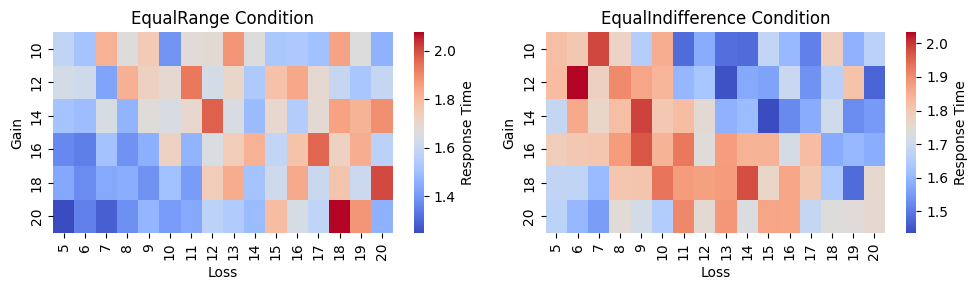

In [16]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
hmap_data = data.query("condition == 'equalRange' & gain in @shared_gains").groupby(['gain', 'loss'])['RT'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[0])
axs[0].set_title("EqualRange Condition")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference' & gain in @shared_gains").groupby(['gain', 'loss'])['RT'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[1])
axs[1].set_title("EqualIndifference Condition")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

### Visualization of acceptance rate

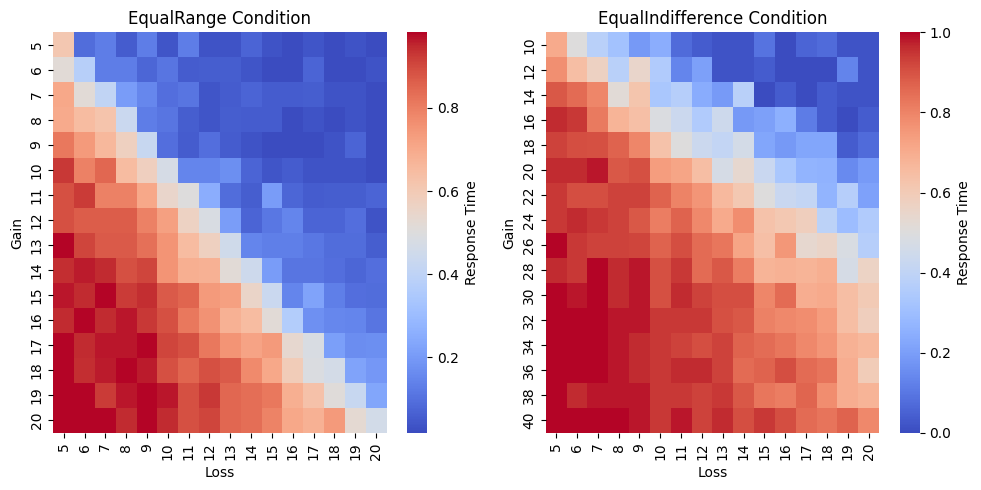

In [18]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("condition == 'equalRange'").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[0])
axs[0].set_title("EqualRange Condition")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[1])
axs[1].set_title("EqualIndifference Condition")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

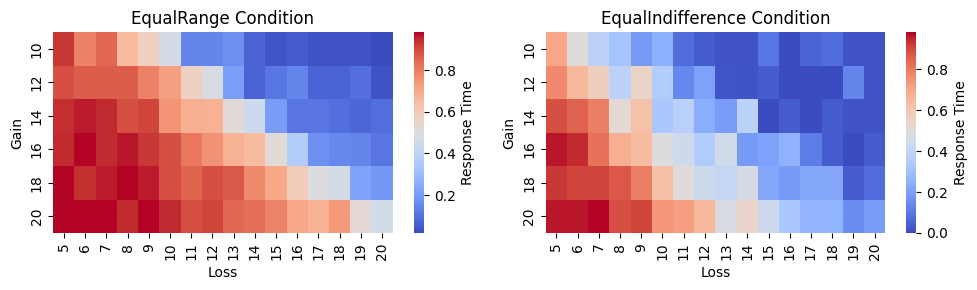

In [19]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
hmap_data = data.query("condition == 'equalRange' & gain in @shared_gains").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[0])
axs[0].set_title("EqualRange Condition")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference' & gain in @shared_gains").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[1])
axs[1].set_title("EqualIndifference Condition")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

#### SCRAP
The following is just scrap, will be removed #TODO!

In [54]:
# add new column where its 0 if response_int is 1, 1/3 if its 2, 2/3 if its 3, 1 if its 4
data["prob_accept"] = data["response_int"].replace({1: 0, 2: 1/3, 3: 2/3, 4: 1})


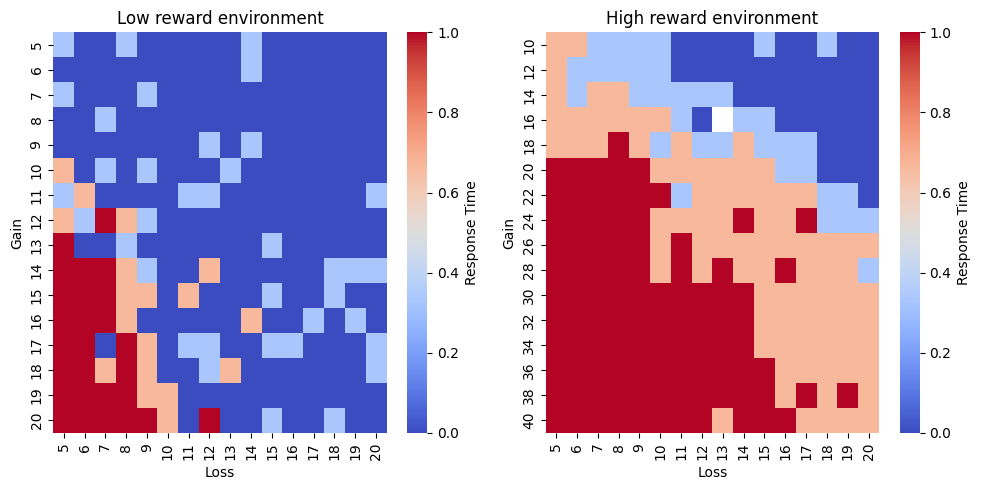

In [65]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("condition == 'equalRange' & sub == 8").groupby(['gain', 'loss'])['prob_accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[0])
axs[0].set_title("Low reward environment")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference' & sub == 9").groupby(['gain', 'loss'])['prob_accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[1])
axs[1].set_title("High reward environment")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

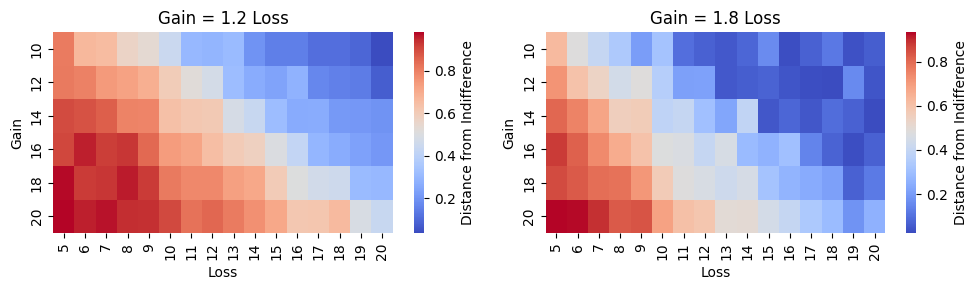

In [58]:
# Two figures: Acceptance rate per condition
shared_gains = [10, 12, 14, 16, 18, 20]
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
hmap_data = data.query("condition == 'equalRange' & gain in @shared_gains").groupby(['gain', 'loss'])['prob_accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Distance from Indifference'}, ax = axs[0])
axs[0].set_title("Gain = 1.2 Loss")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference' & gain in @shared_gains").groupby(['gain', 'loss'])['prob_accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Distance from Indifference'}, ax = axs[1])
axs[1].set_title("Gain = 1.8 Loss")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

In [12]:
shared_gains = [10, 12, 14, 16, 18, 20]
data.query("gain in @shared_gains")

,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,trial
0,1,1,equalIndifference,14,6,2.388,1,3.0,weakly_accept,1
3,1,1,equalIndifference,10,10,1.457,0,2.0,weakly_reject,4
4,1,1,equalIndifference,12,19,1.973,0,1.0,strongly_reject,5
5,1,1,equalIndifference,20,8,1.767,1,3.0,weakly_accept,6
7,1,1,equalIndifference,20,15,2.289,1,3.0,weakly_accept,8
...,...,...,...,...,...,...,...,...,...,...
27636,124,4,equalRange,10,16,1.340,0,1.0,strongly_reject,245
27638,124,4,equalRange,16,11,1.133,1,3.0,weakly_accept,247
27640,124,4,equalRange,16,8,1.339,1,4.0,strongly_accept,249
27642,124,4,equalRange,18,19,1.133,0,2.0,weakly_reject,251


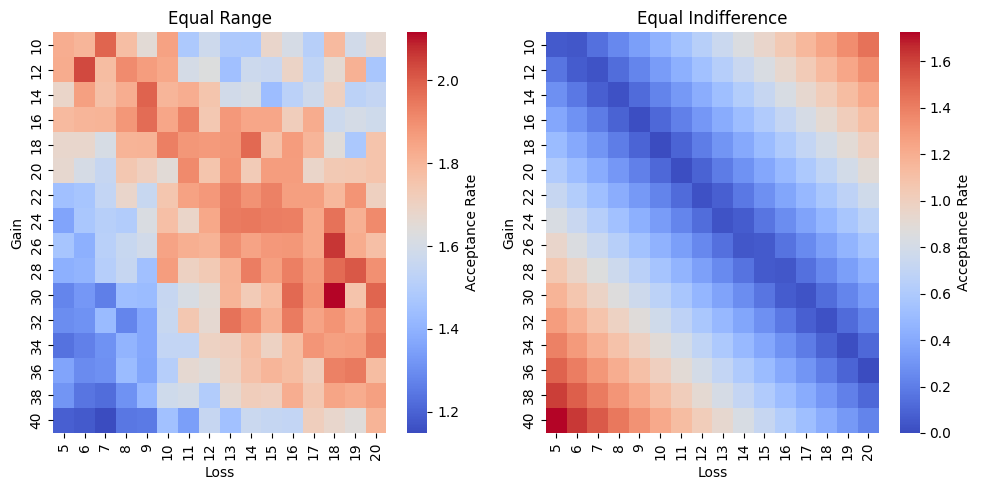

In [57]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['RT'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['dist_from_indiff'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[1])
axs[1].set_title("Equal Indifference")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

Text(95.72222222222221, 0.5, 'Gain')

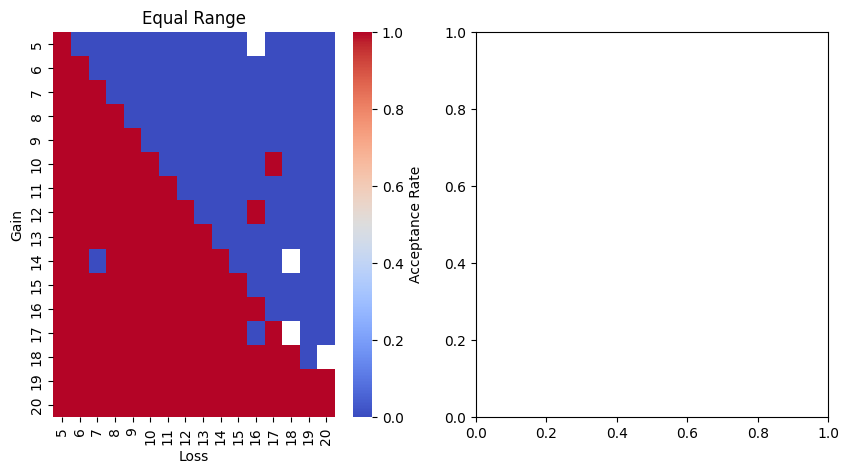

In [9]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("sub == 4").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")